# SETUP ENVIRONMENT (Collab GPU / Dependencies)

In [1]:
!nvidia-smi
!pip install --quiet optuna torch torchvision torchaudio scikit-learn matplotlib pandas numpy gdown

import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, RegressorMixin

import torch, torch.nn as nn, torch.optim as optim
import xgboost as xgb
import optuna
import warnings
warnings.filterwarnings("ignore")

Tue Oct 21 15:50:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# SEED

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device} ({torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'})")

✅ Using device: cuda (Tesla T4)


# DATA LOADING

In [3]:
from google.colab import drive
drive.mount('/content/drive')

file_id = "1a8XaGByqoz9xmpsFylUf7HXXAfOx8Aj2"
url = f"https://drive.google.com/uc?id={file_id}"
output = "EEW_features_2024-10-21.csv"
import gdown
gdown.download(url, output, quiet=False)

df = pd.read_csv(output, skiprows=[1])
df.columns = df.columns.str.strip()

for col in df.columns:
    if col not in ['filename', 'date', 'time']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.fillna(df.median(numeric_only=True))

p_wave_features = ['pkev12', 'pkev23', 'durP', 'tauPd', 'tauPt',
                   'PDd', 'PVd', 'PAd', 'PDt', 'PVt', 'PAt',
                   'ddt_PDd', 'ddt_PVd', 'ddt_PAd', 'ddt_PDt', 'ddt_PVt', 'ddt_PAt']

df = df[(df[p_wave_features] > 0).all(axis=1)]

X = df[p_wave_features]
y_raw = df['PGA']
X = np.log1p(X)
y_log = np.log1p(y_raw)

Mounted at /content/drive


Downloading...
From: https://drive.google.com/uc?id=1a8XaGByqoz9xmpsFylUf7HXXAfOx8Aj2
To: /content/EEW_features_2024-10-21.csv
100%|██████████| 6.82M/6.82M [00:00<00:00, 30.8MB/s]


# STRATIFIED SPLITTING
  To Preserve Distribution

In [4]:
y_bins = pd.qcut(y_log, q=10, labels=False, duplicates='drop')
sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, temp_idx = next(sss1.split(X, y_bins))
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=0.5, random_state=42)
val_idx, test_idx = next(sss2.split(X.iloc[temp_idx], y_bins.iloc[temp_idx]))
val_idx, test_idx = temp_idx[val_idx], temp_idx[test_idx]

X_train, X_val, X_test = X.iloc[train_idx], X.iloc[val_idx], X.iloc[test_idx]
y_train_log, y_val_log, y_test_log = y_log.iloc[train_idx], y_log.iloc[val_idx], y_log.iloc[test_idx]
y_train_raw, y_val_raw, y_test_raw = y_raw.iloc[train_idx], y_raw.iloc[val_idx], y_raw.iloc[test_idx]

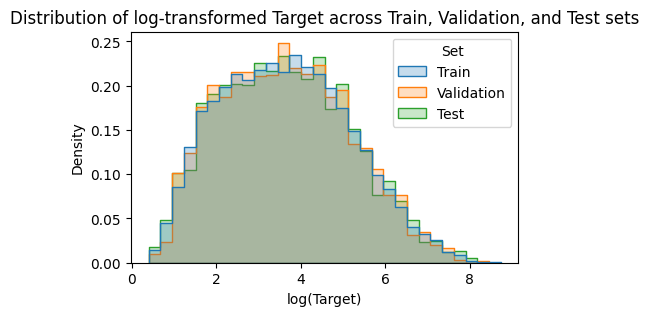

In [5]:
plot_df = pd.DataFrame({
    'Target (Log)': pd.concat([y_train_log, y_val_log, y_test_log], axis=0),
    'Set': ['Train']*len(y_train_log) + ['Validation']*len(y_val_log) + ['Test']*len(y_test_log)
})

plt.figure(figsize=(5,3))
sns.histplot(data=plot_df, x='Target (Log)', hue='Set', element='step', stat='density', common_norm=False, bins=30)
plt.title('Distribution of log-transformed Target across Train, Validation, and Test sets')
plt.xlabel('log(Target)')
plt.ylabel('Density')
plt.show()

# EVALUATION METRICES

In [6]:
def evaluate(model, X, y_log, y_raw):
    preds_log = model.predict(X)
    preds_raw = np.expm1(preds_log)

    metrics_log = {
        'R2': r2_score(y_log, preds_log),
        'MAE': mean_absolute_error(y_log, preds_log),
        'RMSE': np.sqrt(mean_squared_error(y_log, preds_log))
    }

    metrics_raw = {
        'R2': r2_score(y_raw, preds_raw),
        'MAE': mean_absolute_error(y_raw, preds_raw),
        'RMSE': np.sqrt(mean_squared_error(y_raw, preds_raw))
    }

    return metrics_log, metrics_raw

In [12]:
scaler = RobustScaler().fit(X_train)
imputer = SimpleImputer(strategy='mean').fit(X_train)
selector = SelectKBest(score_func=f_regression, k='all').fit(X_train, y_train_log)

X_train_sel = selector.transform(imputer.transform(scaler.transform(X_train)))
X_val_sel = selector.transform(imputer.transform(scaler.transform(X_val)))
X_test_sel = selector.transform(imputer.transform(scaler.transform(X_test)))

# XGBOOST MODEL

In [13]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    y_bins_cv = pd.qcut(y_train_log, q=10, labels=False, duplicates='drop')
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    mae_scores = []

    for tr_idx, val_idx in skf.split(X_train, y_bins_cv):
        X_tr, X_val_split = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val_split = y_train_log.iloc[tr_idx], y_train_log.iloc[val_idx]

        scaler = RobustScaler()
        imputer = SimpleImputer(strategy='mean')
        selector = SelectKBest(score_func=f_regression, k='all')

        X_tr_prep = selector.fit_transform(imputer.fit_transform(scaler.fit_transform(X_tr)), y_tr)
        X_val_prep = selector.transform(imputer.transform(scaler.transform(X_val_split)))

        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42
        )

        model.fit(X_tr_prep, y_tr)
        preds = model.predict(X_val_prep)
        mae_scores.append(mean_absolute_error(y_val_split, preds))

    return np.mean(mae_scores)

#TRAINING IN OPTIMAL HYPERPARAMETER SPACE

In [14]:
best_params = {'n_estimators': 776, 'learning_rate': 0.010590433420511285, 'max_depth': 6, 'subsample': 0.666852461341688, 'colsample_bytree': 0.8724127328229327}

final_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)

final_xgb.fit(X_train_sel, y_train_log)

pred_train_log = final_xgb.predict(X_train_sel)
pred_val_log = final_xgb.predict(X_val_sel)
pred_test_log = final_xgb.predict(X_test_sel)

pred_train_raw = np.expm1(pred_train_log)
pred_val_raw = np.expm1(pred_val_log)
pred_test_raw = np.expm1(pred_test_log)

def evaluate(y_true_log, y_pred_log, y_true_raw, y_pred_raw):
    metrics_log = {
        'R2': r2_score(y_true_log, y_pred_log),
        'MAE': mean_absolute_error(y_true_log, y_pred_log),
        'RMSE': np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    }
    metrics_raw = {
        'R2': r2_score(y_true_raw, y_pred_raw),
        'MAE': mean_absolute_error(y_true_raw, y_pred_raw),
        'RMSE': np.sqrt(mean_squared_error(y_true_raw, y_pred_raw))
    }
    return metrics_log, metrics_raw

metrics_train_log, metrics_train_raw = evaluate(y_train_log, pred_train_log, y_train_raw, pred_train_raw)
metrics_val_log, metrics_val_raw = evaluate(y_val_log, pred_val_log, y_val_raw, pred_val_raw)
metrics_test_log, metrics_test_raw = evaluate(y_test_log, pred_test_log, y_test_raw, pred_test_raw)

print("XGBoost Evaluation Metrics (Log Scale):")
print(pd.DataFrame({'Train': metrics_train_log, 'Val': metrics_val_log, 'Test': metrics_test_log}).T)

print("\nXGBoost Evaluation Metrics (Raw Scale):")
print(pd.DataFrame({'Train': metrics_train_raw, 'Val': metrics_val_raw, 'Test': metrics_test_raw}).T)


XGBoost Evaluation Metrics (Log Scale):
             R2       MAE      RMSE
Train  0.883789  0.406510  0.520045
Val    0.844688  0.460052  0.594843
Test   0.851216  0.462608  0.594265

XGBoost Evaluation Metrics (Raw Scale):
             R2        MAE        RMSE
Train  0.807357  42.483300  114.954619
Val    0.779588  45.705212  115.658942
Test   0.773958  49.600511  131.553941


# SLIGHT IMPROVEMENT FOUND